# Subject: Machine Learning, 1st March 2024 to 3rd May 2024.
## Topic: Group Project (Task B)
## Learning Outcomes:
- MO2: Select and apply machine learning algorithms to formulate 
solutions to different types of machine learning problems, taking 
into account criteria such data availability and characteristics, and 
problem-specific requirements for balancing speed, accuracy, and 
explainability.

- MO3: Implement and evaluate contemporary machine learning 
solutions to application problems using a range of contemporary 
frameworks.

- MO4: Demonstrate an awareness of the ethical and societal 
implications of machine learning solutions. 

In [77]:
import subprocess
import os


current_directory = os.path.dirname(os.path.abspath("main.ipynb"))
current_directory += "/"

def install(requirements):
    """
    Install all the relevent project dependencies.
    """

    try:
        if os.path.isdir('.venv'):
            activate_script = os.path.join('.venv', 'bin', 'activate')
            subprocess.check_call(['source', activate_script], shell=True)

        with open(requirements, 'r') as f:
            requirements = f.read().splitlines()
            subprocess.check_call(['pip', 'install'] + requirements)
        print("Installed dependencies.")

    except FileNotFoundError:
        print(f"File '{requirements}' not found.")
    except subprocess.CalledProcessError:
        pass

if __name__ == "__main__":
    install(current_directory + "project/requirements.txt")



Installed dependencies.


In [78]:
import pandas as pd
import datetime as dt
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

raw_data = pd.read_csv(current_directory + "project/raw_data/BTC-USD.csv")
df = raw_data[["Date", "Close"]]

def to_datetime(s: str):
    year, month, day = s.split("-")
    return dt.datetime(
        int(year),
        int(month),
        int(day)
    )

date = df["Date"]
close_prices = df["Close"]
date = date.apply(to_datetime)
df.index = df.pop("Date")
print(df)

                   Close
Date                    
2020-03-08   8108.116211
2020-03-09   7923.644531
2020-03-10   7909.729492
2020-03-11   7911.430176
2020-03-12   4970.788086
...                  ...
2024-03-05  63801.199219
2024-03-06  66106.804688
2024-03-07  66925.484375
2024-03-08  68300.093750
2024-03-09  68498.882812

[1463 rows x 1 columns]


## Features and Data Normalisation
Get the training set, validation set and test set for the model to work.

In [83]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Numpy Univariate Time Series, if needed.
# close_prices = np.array(close).reshape(-1, 1)

# Split sizes
train_size = 0.6
validation_size = 0.20
test_size = 0.20

# Split the data into train and test
X_train, X_test =  train_test_split(close_prices, test_size=test_size, shuffle=False)

validation_size = validation_size / (1.0 - test_size)

# Split the train data to get a validation set
X_train, X_validation = train_test_split(X_train, test_size=validation_size, shuffle=False)

print("Training set:", len(X_train)/len(close_prices), "%")
print("Validation set:", len(X_validation)/len(close_prices), "%")
print("Test set:", len(X_test)/len(close_prices), "%")

Training set: 0.6493506493506493 %
Validation set: 0.20027341079972658 %
Test set: 0.15037593984962405 %


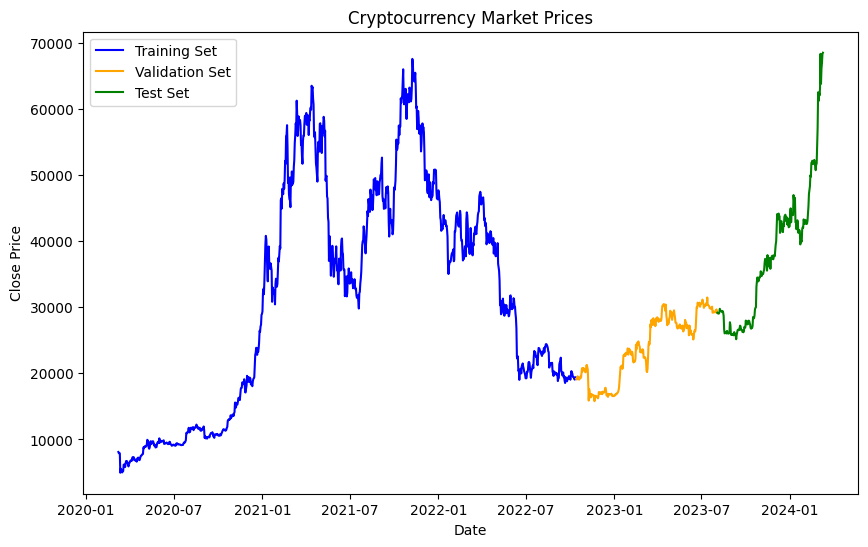

In [88]:
import matplotlib.pyplot as plt

# Plot close prices for training, validation, and test sets
plt.figure(figsize=(10, 6))

# Plot training set
plt.plot(date[:len(X_train)], X_train, label='Training Set', color='blue')

# Plot validation set
plt.plot(date[len(X_train):len(X_train) + len(X_validation)], X_validation, label='Validation Set', color='orange')

# Plot test set
plt.plot(date[len(X_train) + len(X_validation):], X_test, label='Test Set', color='green')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Cryptocurrency Market Prices")
plt.legend()
plt.show()